# TIME SERIES CLASSIFIER (RENergetic)

ALGORITHM TYPE: time series classifier from tslearn API
>NAME Algorithm:  TimeSeriesSVC 

>OBJECTIVE: classification of heat energy time series for heat consumption (MWh) in Dibit 2 building in OSR

>             classify into RENergetic Index binary values:: 1=inefficient consumtion  0=efficient consumption

Samplig Rate: 24 hr PREDICTION: profile


MW consumption Dibit2 from 8-Nov-2020 07:00:00 to 9-Nov-2020 22:00:00

NOTE @10-11-21 model is draft demo purpose only (no cross-validation and manual hypermparmenter optimization is provided at the moment)

### INITIAL DATA ENGINEERING

In [1]:
#import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_squared_error   

In [2]:
#check working directory
import os
CURR_DIR=os.getcwd()
print(CURR_DIR)

C:\Users\DANIELE\Anaconda3\envs\RENergectic_Forecasting_Models_


In [3]:
%matplotlib inline

In [4]:
df_base=pd.read_excel('Summer_Period_Dibit2_V04_REPLICA.xlsx')  #fetch dataframe
df_base=df_base[['timestamp','MW']]                             #data preprocessing (configuration)
# print(df_base.dtypes)

In [5]:
df_base['in_period']=df_base['timestamp'].dt.month              #extract month
df_base['day']=df_base['timestamp'].dt.day                      #extract day
df_base['hr']=df_base['timestamp'].dt.hour                      #extract hour
df_base

,timestamp,MW,in_period,day,hr
0,2020-08-15 00:00:00,0.94,8,15,0
1,2020-08-15 01:00:00,0.94,8,15,1
2,2020-08-15 02:00:00,1.07,8,15,2
3,2020-08-15 03:00:00,0.91,8,15,3
4,2020-08-15 04:00:00,0.99,8,15,4
...,...,...,...,...,...
2083,2020-11-09 19:00:00,1.76,11,9,19
2084,2020-11-09 20:00:00,1.76,11,9,20
2085,2020-11-09 21:00:00,1.91,11,9,21
2086,2020-11-09 22:00:00,2.01,11,9,22


In [6]:
df_base=df_base[['timestamp','in_period','day','hr','MW']]         #reordering dataframe
df_base

,timestamp,in_period,day,hr,MW
0,2020-08-15 00:00:00,8,15,0,0.94
1,2020-08-15 01:00:00,8,15,1,0.94
2,2020-08-15 02:00:00,8,15,2,1.07
3,2020-08-15 03:00:00,8,15,3,0.91
4,2020-08-15 04:00:00,8,15,4,0.99
...,...,...,...,...,...
2083,2020-11-09 19:00:00,11,9,19,1.76
2084,2020-11-09 20:00:00,11,9,20,1.76
2085,2020-11-09 21:00:00,11,9,21,1.91
2086,2020-11-09 22:00:00,11,9,22,2.01


In [7]:
adf=df_base
day=adf.join(adf.groupby(['in_period','day'])['MW'].mean(),on=['in_period','day'],rsuffix='_d')   #day object generates MW_d (=daily (24hrs) average MW consumption)
period=day.join(day.groupby(['in_period'])['MW'].mean(),on=['in_period'],rsuffix='_p')            #period object generates MW_p (=in-period (month) average MW consumption )
period.head()

,timestamp,in_period,day,hr,MW,MW_d,MW_p
0,2020-08-15 00:00:00,8,15,0,0.94,0.985417,1.009877
1,2020-08-15 01:00:00,8,15,1,0.94,0.985417,1.009877
2,2020-08-15 02:00:00,8,15,2,1.07,0.985417,1.009877
3,2020-08-15 03:00:00,8,15,3,0.91,0.985417,1.009877
4,2020-08-15 04:00:00,8,15,4,0.99,0.985417,1.009877


In [8]:
mhr=period.groupby(['in_period','day']).mean()                           #aggregating by .groupby on all numeric features(hr, MW, MW_d, MW_p)
mhr=pd.DataFrame(mhr)
mhr

hr        MW      MW_d      MW_p
in_period day                                    
8         15   11.5  0.985417  0.985417  1.009877
          16   11.5  0.977083  0.977083  1.009877
          17   11.5  1.005833  1.005833  1.009877
          18   11.5  0.990417  0.990417  1.009877
          19   11.5  0.992083  0.992083  1.009877
...             ...       ...       ...       ...
11        5    11.5  1.780000  1.780000  1.918750
          6    11.5  1.776667  1.776667  1.918750
          7    11.5  1.992917  1.992917  1.918750
          8    11.5  2.013750  2.013750  1.918750
          9    11.5  2.014167  2.014167  1.918750

[87 rows x 4 columns]

# PLOT TIME SERIES DATA 

In [9]:
#main pivot action to transpose MW per hour as hourly columns
piv=period.pivot(index=['in_period','day'], columns='hr', values='MW')
piv[['MW_d','MW_p']]=mhr[['MW_d','MW_p']]
piv

hr                0     1     2     3     4     5     6     7     8     9  \
in_period day                                                               
8         15   0.94  0.94  1.07  0.91  0.99  0.95  0.99  0.96  0.97  0.91   
          16   1.04  1.01  0.96  0.98  1.04  1.01  1.01  1.00  0.96  0.99   
          17   1.02  0.95  1.00  0.94  0.93  0.95  0.98  1.06  0.98  1.05   
          18   0.91  0.95  0.98  0.97  0.98  0.94  0.95  0.97  1.00  1.05   
          19   0.95  1.00  1.01  0.99  1.00  1.14  0.92  0.97  1.05  0.99   
...             ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
11        5    1.88  1.74  1.81  1.72  1.92  1.87  1.97  1.98  1.97  2.23   
          6    1.92  1.79  1.71  1.80  1.88  1.85  1.88  1.76  2.00  2.00   
          7    1.94  2.04  2.05  2.00  2.13  2.14  2.14  2.25  2.25  2.24   
          8    1.86  2.16  2.25  2.29  2.37  2.30  2.31  2.33  2.26  2.32   
          9    2.16  2.28  2.19  2.25  2.25  2.25  2.26  2.30  2.26  2.06   

hr             ...    16    17    18    19    20    21    22    23      MW_d  \
in_period day  ...                                                             
8         15   ...  0.98  1.02  0.99  1.11  1.03  1.01  1.04  1.03  0.985417   
          16   ...  0.96  1.06  1.14  0.00  1.06  1.00  0.95  0.95  0.977083   
          17   ...  1.12  1.05  1.14  1.00  1.05  0.97  0.98  1.02  1.005833   
          18   ...  1.09  0.94  1.08  0.96  0.89  0.90  0.97  0.95  0.990417   
          19   ...  0.92  1.09  0.91  1.05  0.93  0.93  1.02  0.96  0.992083   
...            ...   ...   ...   ...   ...   ...   ...   ...   ...       ...   
11        5    ...  1.54  1.59  1.83  1.90  1.67  1.76  1.79  1.82  1.780000   
          6    ...  1.44  1.64  1.72  1.81  1.76  1.88  1.86  1.84  1.776667   
          7    ...  1.86  1.80  1.93  1.85  1.95  1.74  2.02  2.12  1.992917   
          8    ...  1.70  1.68  1.70  1.98  1.85  1.94  1.98  2.06  2.013750   
          9    ...  1.76  1.73  1.74  1.76  1.76  1.91  2.01  2.17  2.014167   

hr                 MW_p  
in_period day            
8         15   1.009877  
          16   1.009877  
          17   1.009877  
          18   1.009877  
          19   1.009877  
...                 ...  
11        5    1.918750  
          6    1.918750  
          7    1.918750  
          8    1.918750  
          9    1.918750  

[87 rows x 26 columns]

# plot days trends (MW per hour)

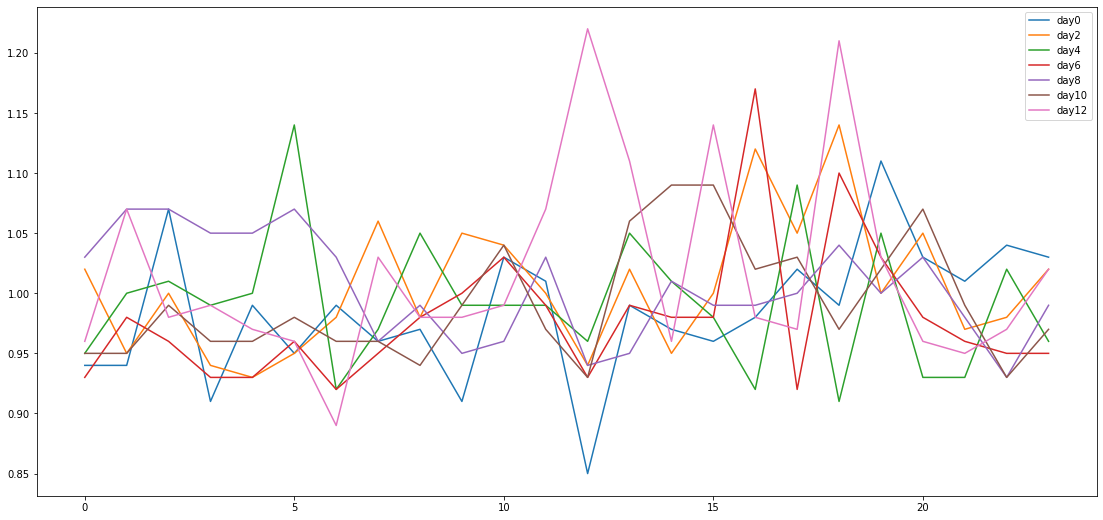

In [10]:
#plotting MW per hour (removing MW_d and MW_p from the index to plot easily)
piv_plot=period.pivot(index=['in_period','day'], columns='hr', values='MW')
# piv_plot

piv_plot.reset_index(drop=True, inplace=True)
# piv_plot.T

sampled_plot=piv_plot.T[[0,2,4,6,8,10,12]]               #2 day sampling frequency
# sampled_plot

# plot forecasts against actual outcomes
f = plt.figure()
f.set_figwidth(19)
f.set_figheight(9)
plt.plot(sampled_plot)
plt.legend(['day0','day2','day4','day6','day8','day10','day12'])
plt.show()

In [11]:
piv['REN_Index']=piv['MW_d']/piv['MW_p']                             #calculating the RENergetic Index (REN-Index)
piv.tail()

hr                0     1     2     3     4     5     6     7     8     9  \
in_period day                                                               
11        5    1.88  1.74  1.81  1.72  1.92  1.87  1.97  1.98  1.97  2.23   
          6    1.92  1.79  1.71  1.80  1.88  1.85  1.88  1.76  2.00  2.00   
          7    1.94  2.04  2.05  2.00  2.13  2.14  2.14  2.25  2.25  2.24   
          8    1.86  2.16  2.25  2.29  2.37  2.30  2.31  2.33  2.26  2.32   
          9    2.16  2.28  2.19  2.25  2.25  2.25  2.26  2.30  2.26  2.06   

hr             ...    17    18    19    20    21    22    23      MW_d  \
in_period day  ...                                                       
11        5    ...  1.59  1.83  1.90  1.67  1.76  1.79  1.82  1.780000   
          6    ...  1.64  1.72  1.81  1.76  1.88  1.86  1.84  1.776667   
          7    ...  1.80  1.93  1.85  1.95  1.74  2.02  2.12  1.992917   
          8    ...  1.68  1.70  1.98  1.85  1.94  1.98  2.06  2.013750   
          9    ...  1.73  1.74  1.76  1.76  1.91  2.01  2.17  2.014167   

hr                MW_p  REN_Index  
in_period day                      
11        5    1.91875   0.927687  
          6    1.91875   0.925950  
          7    1.91875   1.038654  
          8    1.91875   1.049511  
          9    1.91875   1.049729  

[5 rows x 27 columns]

# Compute RENenergetic Index

In [12]:
piv['REN_Index_cat']=piv['REN_Index'].apply(lambda x: '0' if x < 1 else '1')      #REN Index for Classifcation
piv.tail()

hr                0     1     2     3     4     5     6     7     8     9  \
in_period day                                                               
11        5    1.88  1.74  1.81  1.72  1.92  1.87  1.97  1.98  1.97  2.23   
          6    1.92  1.79  1.71  1.80  1.88  1.85  1.88  1.76  2.00  2.00   
          7    1.94  2.04  2.05  2.00  2.13  2.14  2.14  2.25  2.25  2.24   
          8    1.86  2.16  2.25  2.29  2.37  2.30  2.31  2.33  2.26  2.32   
          9    2.16  2.28  2.19  2.25  2.25  2.25  2.26  2.30  2.26  2.06   

hr             ...    18    19    20    21    22    23      MW_d     MW_p  \
in_period day  ...                                                          
11        5    ...  1.83  1.90  1.67  1.76  1.79  1.82  1.780000  1.91875   
          6    ...  1.72  1.81  1.76  1.88  1.86  1.84  1.776667  1.91875   
          7    ...  1.93  1.85  1.95  1.74  2.02  2.12  1.992917  1.91875   
          8    ...  1.70  1.98  1.85  1.94  1.98  2.06  2.013750  1.91875   
          9    ...  1.74  1.76  1.76  1.91  2.01  2.17  2.014167  1.91875   

hr             REN_Index  REN_Index_cat  
in_period day                            
11        5     0.927687              0  
          6     0.925950              0  
          7     1.038654              1  
          8     1.049511              1  
          9     1.049729              1  

[5 rows x 28 columns]

# PLOT RENergetic Index (Dibit2 OSR, 2020 - August November)

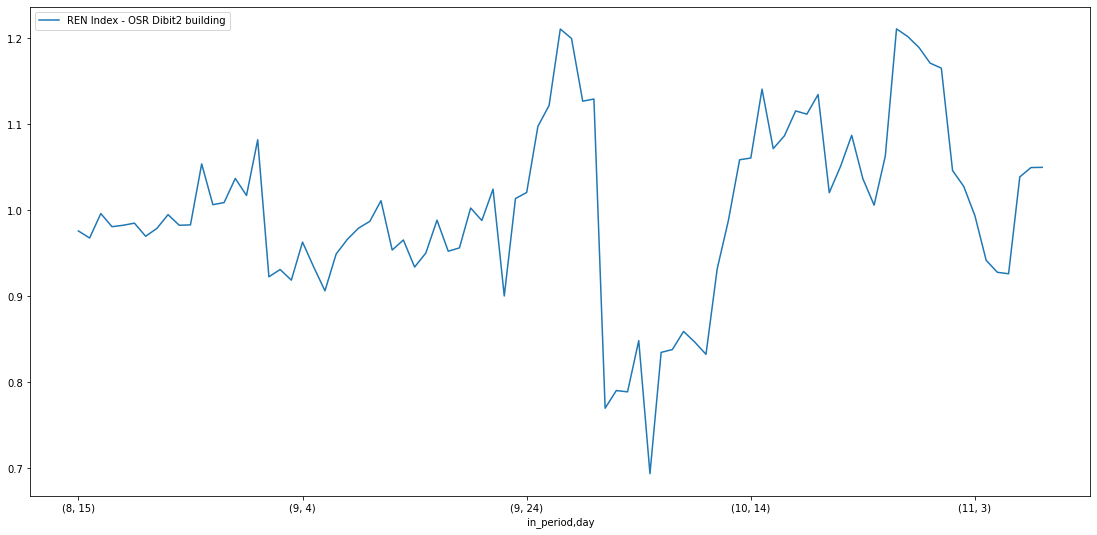

In [13]:
f = plt.figure()
f.set_figwidth(19)
f.set_figheight(9)
piv['REN_Index'].plot()
plt.legend(['REN Index - OSR Dibit2 building']);

# Time Series Support Vector Classifier

## DATA ENGINEERING 

In [14]:
import pandas as pd
from sklearn import model_selection
from tslearn.svm import TimeSeriesSVC                      #timeseries Support Vector Classsifier (by tslearn)
from sklearn.metrics import accuracy_score

Final_df=piv.drop(['MW_d','MW_p','REN_Index'], axis=1)     #finalized dataframe for modeling
# Final_df.head()
# Final_df.info()

array=Final_df.values
X=array[:,0:24]                                          #split series as shape-based feature
y=array[:,24]                                            #split target from series (last value at head of time series)
# print(X.shape,y.shape)

## FIT MODEL 

In [15]:
test_size=0.10                                                            #train test split
seed=34784
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=test_size,random_state=seed)
# print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

clf = TimeSeriesSVC(C=5, kernel="poly", gamma=.1, probability=True)       #TIME SERIES SVC
y_pred=clf.fit(X_train, y_train).predict(X_test)

## MODEL PERFORMACE

In [16]:
accuracy_score(y_test, y_pred)
# print(y_pred)
clf_score_tr=clf.score(X_train, y_train)
print('\nACCURACY (train set):   %.3f %%' % clf_score_tr )
clf_score_te=clf.score(X_test, y_test)
print('\nACCURACY (test set):    %.3f %%' % clf_score_te)

# y_pred_prob = clf.predict_proba(X_test)
# y_pred_prob


ACCURACY (train set):   0.821 %

ACCURACY (test set):    0.778 %


In [17]:
from sklearn.metrics import confusion_matrix                             # Confusion Matrix
confusion_matrix(y_test, y_pred)

array([[4, 1],
       [1, 3]], dtype=int64)

In [18]:
from sklearn.metrics import classification_report                         #a Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.75      0.75      0.75         4

    accuracy                           0.78         9
   macro avg       0.78      0.78      0.78         9
weighted avg       0.78      0.78      0.78         9



# PLOT MODEL
### TARGET: building efficiency (RENenergy Index)

<Figure size 432x288 with 0 Axes>

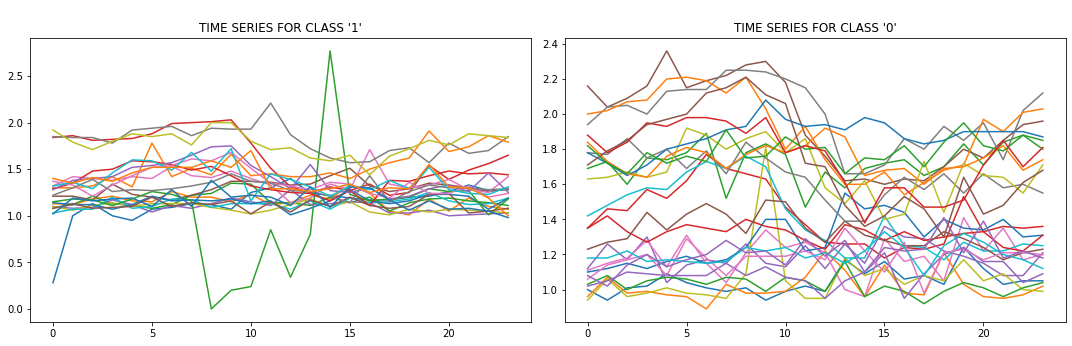

In [19]:
import numpy
import matplotlib.pyplot as plt

n_classes = len(set(y_train))
plt.figure()
support_vectors = clf.support_vectors_
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(9)

for i, cl in enumerate(set(y_train)):
    plt.subplot(n_classes, 2, i + 1)
    plt.title("\nTIME SERIES FOR CLASS %a" % cl)
    for ts in support_vectors[i]:
        
        plt.plot(ts.ravel())

plt.tight_layout()
plt.show()

# Store AI model

In [20]:
import pickle5 as pickle
# save the model to disk
filename = '27_DEMO_2_TimeSeriesSVC_001'
pickle.dump(clf, open(filename, 'wb'))

# UPLOAD AND SCORE NEW DATA

In [ ]:
...

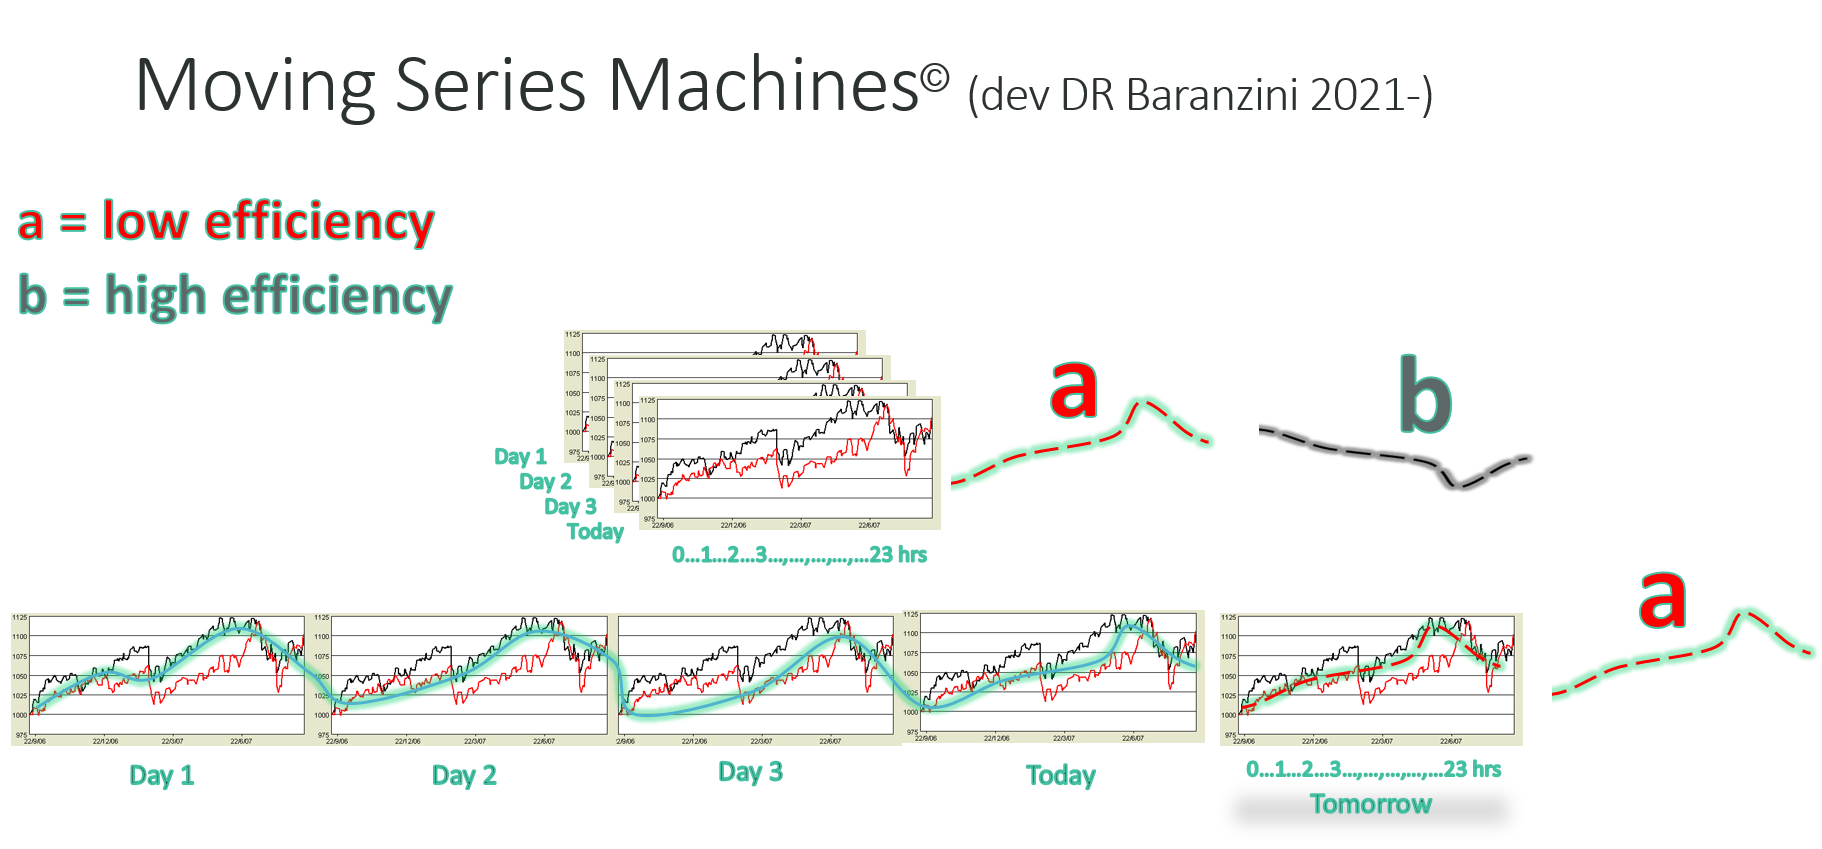

In [21]:
from IPython import display 
display.Image('DEMO2_MSM.png')

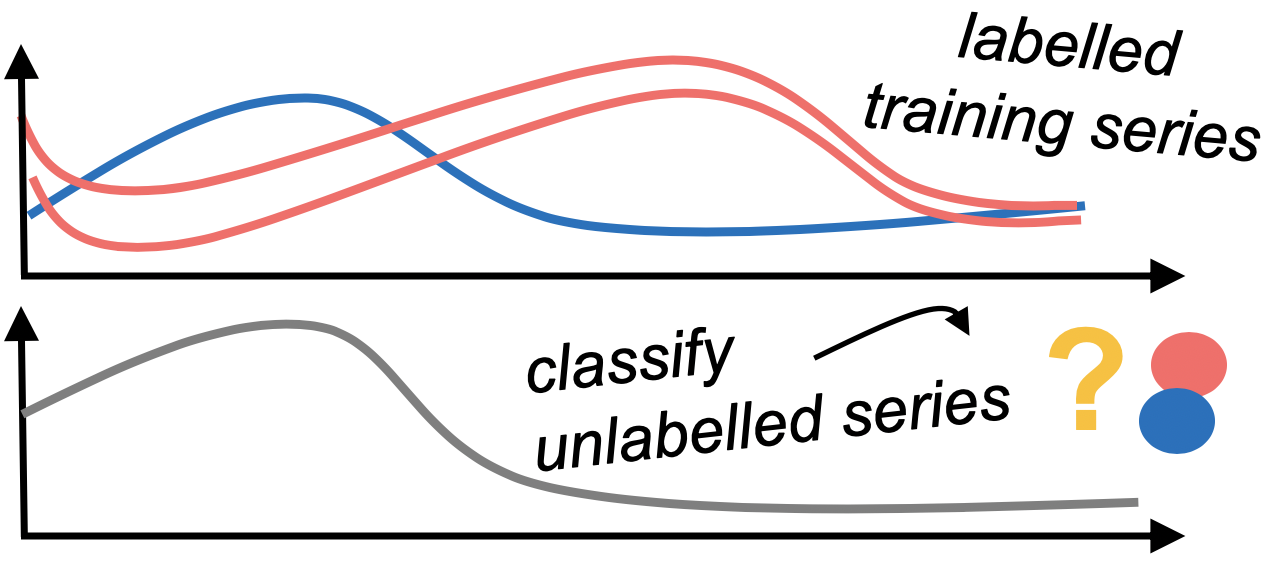

In [22]:
from IPython import display 
display.Image('time-series-classification.png')

end